<a href="https://colab.research.google.com/github/CIGLR-ai-lab/GreatLakes-TempSensors/blob/main/notebooks/05_dcj_active_learning_with_ERA5_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy deepsensor rioxarray

In [ ]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask
from deepsensor.train import set_gpu_default_device

import cartopy.crs as ccrs
import pandas as pd
import xarray as xr

In [ ]:
# Training/data config
data_range = ("2011-01-01", "2011-12-31")
train_range = ("2011-01-01", "2011-08-31")
val_range = ("2011-09-01", "2011-12-31")
date_subsample_factor = 2
station_var_IDs = ["TAVG"]
extent = "north_america"
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = ".datacache"
deepsensor_folder = "deepsensor_config"
model_folder = "model"
verbose_download = True

In [ ]:
# Mounting Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
fpath = '/content/gdrive/MyDrive/CIGLR Summer Fellows/DeepSensor-2024/era5-input-sample/era5_north_america_daily_2011.nc'

In [ ]:
era5_raw_ds = xr.open_dataset(fpath)

In [44]:
print(era5_raw_ds)

  and should_run_async(code)



<xarray.Dataset>
Dimensions:    (longitude: 641, latitude: 313, time: 365)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -20.5 -20.25 -20.0
  * latitude   (latitude) float32 85.0 84.75 84.5 84.25 ... 7.75 7.5 7.25 7.0
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-17 21:03:37 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


In [45]:
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

# Rename dimensions to 'lat' and 'lon'
era5_renamed_ds = era5_raw_ds.rename({'latitude': 'lat', 'longitude': 'lon'})
era5_renamed_ds = era5_renamed_ds.drop(['u10','v10'])

data_processor = DataProcessor(x1_name="lat", x2_name="lon", verbose=True)
era5_ds = data_processor(era5_renamed_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

  and should_run_async(code)



Normalisation params for t2m not computed. Computing now... Done. t2m mean_std params={'mean': 281.0874938964844, 'std': 17.581817626953125}
Inferring x1_map=(7.0, 167.0) and x2_map=(-180.0, -20.0) from data min/max
Normalisation params for elevation not computed. Computing now... Done. elevation min_max params={'min': -6.24999984211172e-06, 'max': 3228.330810546875}
Normalisation params for GLDAS_mask not computed. Computing now... Done. GLDAS_mask min_max params={'min': 0.0, 'max': 1.0}


In [46]:
print(era5_ds)

  and should_run_async(code)



<xarray.Dataset>
Dimensions:  (x2: 641, x1: 313, time: 365)
Coordinates:
  * x2       (x2) float32 0.0 0.001563 0.003125 0.004688 ... 0.9969 0.9984 1.0
  * x1       (x1) float32 0.4875 0.4859 0.4844 0.4828 ... 0.003125 0.001563 0.0
  * time     (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
Data variables:
    t2m      (time, x1, x2) float32 -2.176 -2.169 -2.162 ... 1.054 1.046 1.047
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-17 21:03:37 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


In [47]:
print(lowres_aux_ds)

  and should_run_async(code)



<xarray.Dataset>
Dimensions:    (x2: 120, x1: 72, time: 365)
Coordinates:
  * x2         (x2) float64 0.1276 0.1328 0.138 0.1432 ... 0.737 0.7422 0.7474
  * x1         (x1) float64 0.4214 0.4161 0.4109 ... 0.06198 0.05677 0.05156
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
Data variables:
    elevation  (x1, x2) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -0.9795 -1.0
    cos_D      (time) float64 0.9999 0.9994 0.9987 0.9976 ... 0.9993 0.9998 1.0
    sin_D      (time) float64 0.0172 0.0344 0.05158 ... -0.0215 -0.004301


In [48]:
print(land_mask_ds)

  and should_run_async(code)



<xarray.DataArray 'GLDAS_mask' (x1: 240, x2: 400)>
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)
Coordinates:
  * x2       (x2) float32 0.1258 0.1273 0.1289 0.1305 ... 0.7461 0.7477 0.7492
  * x1       (x1) float32 0.4242 0.4227 0.4211 ... 0.05391 0.05234 0.05078


In [49]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

  and should_run_async(code)



TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('t2m',),)


In [ ]:
set_gpu_default_device()

In [51]:
# Load model
model = ConvNP(data_processor, task_loader)

  and should_run_async(code)



dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 639
encoder_scales inferred from TaskLoader: [0.0007812500116415322, 0.0007812500116415322, 0.0026041665114462376]
decoder_scale inferred from TaskLoader: 0.001564945226917058


In [ ]:
from deepsensor.active_learning import GreedyAlgorithm

alg = GreedyAlgorithm(
    model,
    X_s=era5_renamed_ds,
    X_t=era5_renamed_ds,
    X_s_mask=land_mask_raw_ds,
    X_t_mask=land_mask_raw_ds,
    context_set_idx=0,
    target_set_idx=0,
    N_new_context=3,
    progress_bar=True,
)

In [ ]:
from deepsensor.active_learning.acquisition_fns import Stddev

acquisition_fn = Stddev(model, context_set_idx=0, target_set_idx=0)

In [54]:
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
placement_dates = val_dates
placement_tasks = task_loader(placement_dates, context_sampling=[100, "all", "all"], seed_override=0)

X_new_df, acquisition_fn_ds = alg(acquisition_fn, placement_tasks)

  and should_run_async(code)

100%|██████████| 183/183 [00:26<00:00,  6.78it/s]


In [55]:
X_new_df

  and should_run_async(code)



,lat,lon
iteration,,
0,38.5,-105.75
1,38.0,-106.00
2,37.5,-106.25


  and should_run_async(code)

  warnings.warn(f'Downloading: {url}', DownloadWarning)



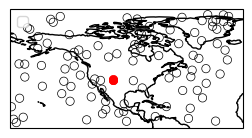

In [56]:
fig = deepsensor.plot.placements(placement_tasks[0], X_new_df, data_processor,
                                 crs=ccrs.PlateCarree())

  and should_run_async(code)



Averaging acquisition function over dims for plotting: ['time']


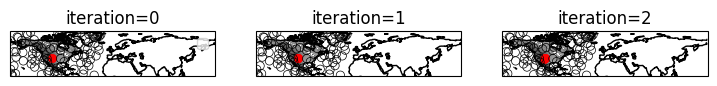

In [57]:
fig = deepsensor.plot.acquisition_fn(
    placement_tasks[0], acquisition_fn_ds, X_new_df,
    data_processor, crs=ccrs.PlateCarree(), add_colorbar=False,
    cmap="Greys")